In [81]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

import numpy as np
from os.path import join
import os


In [177]:
roof_dir = './sample/curated/roofs'
materials = ['healthy_metal', 'irregular_metal', 'concrete_cement', 'incomplete', 'other']

### Calculate features

This uses a pretrained network to compute features from the images, which are later classified.
First, load the model, from which we remove the top layer

In [178]:
model = ResNet50(weights='imagenet', include_top=False, pooling='max')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

In [179]:
# Count the number of images
nof_roofs = 0;
for material in materials:
    material_fp = join(roof_dir, material)
    nof_roofs = nof_roofs + (len([name for name in os.listdir(material_fp) if os.path.isfile(join(material_fp, name))]))
print(nof_roofs)

labels = []
resnet50_feature_matrix = np.zeros((nof_roofs, 2048), dtype=float)



# Walk through all images
for material in materials:
    material_fp = join(roof_dir, material)
    for root, dirs, files in os.walk(material_fp):
        i = 0;
        for file in files:
            img_fp = join(material_fp, file)
            
            label = materials.index(material)
            labels.append(label)
            print(img_fp, label)
    
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)

            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)
            resnet50_feature = model.predict(img_data)
            resnet50_feature_np = np.array(resnet50_feature)
            
            #print(resnet50_feature_np.shape)
            
            resnet50_feature_matrix[i] = resnet50_feature_np.flatten()
            i = i+1;

resnet50_feature_list_np = np.array(resnet50_feature_list)

95
./sample/curated/roofs\healthy_metal\7a1ea402.tif 0
./sample/curated/roofs\healthy_metal\7a1ec590.tif 0
./sample/curated/roofs\healthy_metal\7a1f387c.tif 0
./sample/curated/roofs\healthy_metal\7a1f5d2a.tif 0
./sample/curated/roofs\healthy_metal\7a1fb914.tif 0
./sample/curated/roofs\healthy_metal\7a206832.tif 0
./sample/curated/roofs\healthy_metal\7a2176f0.tif 0
./sample/curated/roofs\healthy_metal\7a2246c0.tif 0
./sample/curated/roofs\healthy_metal\7a237ca2.tif 0
./sample/curated/roofs\healthy_metal\7a239db8.tif 0
./sample/curated/roofs\healthy_metal\7a243732.tif 0
./sample/curated/roofs\healthy_metal\7a24afdc.tif 0
./sample/curated/roofs\healthy_metal\7a268d34.tif 0
./sample/curated/roofs\healthy_metal\7a270836.tif 0
./sample/curated/roofs\healthy_metal\7a272bb8.tif 0
./sample/curated/roofs\healthy_metal\7a285844.tif 0
./sample/curated/roofs\healthy_metal\7a287d4c.tif 0
./sample/curated/roofs\healthy_metal\7a297b48.tif 0
./sample/curated/roofs\healthy_metal\7a2af284.tif 0
./sample/

### Visualize the features

Reduce the dimensionality to 2D using tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [197]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [198]:
def plot_tSNE(features, labels=None, number_of_materials=5):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    # Visualization_
    #pca_object = PCA(n_components=50)
    #pca_features = pca_object.fit_transform(features)
    tsne_features = TSNE(n_components=3).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    
    
    # Plot D-Vectors
    fig = plt.figure()
    ax = Axes3D(fig)
    
    scat = ax.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    #cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)

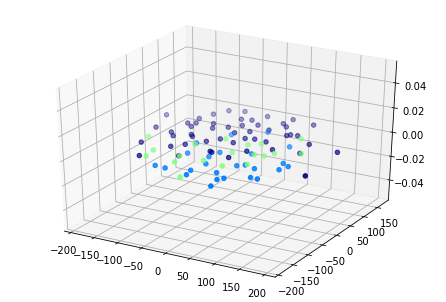

In [199]:
plot_tSNE(resnet50_feature_matrix, labels)

### Classify the samples using a SVM

In [188]:
from sklearn import svm

In [189]:
clf = svm.SVC(gamma='auto', probability=True, decision_function_shape='ovo')
clf.fit(resnet50_feature_matrix, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [190]:
predictions = clf.predict_proba(resnet50_feature_matrix)

for i in range(len(predictions)):
    print(predictions[i], labels[i])

[0.96852628 0.01542566 0.01604806] 0
[0.96851775 0.01542989 0.01605236] 0
[0.96851405 0.01543173 0.01605423] 0
[0.96851785 0.01542984 0.01605231] 0
[0.96851508 0.01543122 0.01605371] 0
[0.96860499 0.01538661 0.01600841] 0
[0.96851944 0.01542905 0.01605151] 0
[0.96860426 0.01538697 0.01600878] 0
[0.96851536 0.01543107 0.01605356] 0
[0.96860132 0.01538842 0.01601025] 0
[0.96860073 0.01538872 0.01601055] 0
[0.96860076 0.0153887  0.01601054] 0
[0.96852908 0.01542427 0.01604665] 0
[0.96851944 0.01542905 0.01605151] 0
[0.96851807 0.01542973 0.0160522 ] 0
[0.96851786 0.01542983 0.0160523 ] 0
[0.96852627 0.01542566 0.01604807] 0
[0.96852007 0.01542874 0.01605119] 0
[0.96860096 0.0153886  0.01601044] 0
[0.96860433 0.01538693 0.01600874] 0
[0.96860329 0.01538745 0.01600926] 0
[0.96851453 0.01543149 0.01605398] 0
[0.96860298 0.0153876  0.01600942] 0
[0.96860268 0.01538775 0.01600957] 0
[0.96851775 0.01542989 0.01605236] 0
[0.96860019 0.01538899 0.01601083] 0
[0.96860136 0.01538841 0.01601024] 0
[